In [101]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
# %matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import os
import scipy.io
import neuronumba
import scipy.integrate as integrate
from scipy.linalg import expm
from scipy.linalg import solve_continuous_lyapunov
from typing import Union
#
from DataLoaders.baseDataLoader import DataLoader
import ADNI_A


from functions_FDT_numba_v8 import *

from functions_boxplots_WN3_v0 import *
from functions_boxplots_WN3_v0 import plot_boxes_HC_MCI_AD
import filterps
from functions_violinplots_WN3_v0 import plot_violins_HC_MCI_AD

In [173]:
DL = ADNI_A.ADNI_A()

# Loading the data for all subjects
HC_IDs = DL.get_groupSubjects('HC')
HC_MRI = {}
for subject in HC_IDs:
    data = DL.get_subjectData(subject)
    HC_MRI[subject] = data[subject]['timeseries'].transpose()

MCI_IDs = DL.get_groupSubjects('MCI')
MCI_MRI = {}
for subject in MCI_IDs:
    data = DL.get_subjectData(subject)
    MCI_MRI[subject] = data[subject]['timeseries'].transpose()

AD_IDs = DL.get_groupSubjects('AD')
AD_MRI = {}
for subject in AD_IDs:
    data = DL.get_subjectData(subject)
    AD_MRI[subject] = data[subject]['timeseries'].transpose()

# Okay this is loading in the effecetive connectivity, so we cannot use this for f_diff
# we need to use the data loader to get the timeseries data
EC_HC_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/HC_FDT_results_filters0109.mat')
EC_MCI_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/MCI_FDT_results_filters0109.mat')
EC_AD_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/AD_FDT_results_filters0109.mat')
#print(EC_HC_data.keys()) # check the keys

#print(EC_MCI_data['Ceff_subjects'])
print(len(EC_HC_data['Ceff_subjects'])) # check the number of subjects
print(len(EC_MCI_data['Ceff_subjects'])) # check the number of subjects
print(len(EC_AD_data['Ceff_subjects'])) # check the number of subjects
NPARCELLS = len(EC_AD_data['Ceff_subjects'][0])



cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
17
9
10


In [163]:
def calc_H_freq(
        all_HC_fMRI: Union[np.ndarray, dict], 
        tr: float, 
        version: filterps.FiltPowSpetraVersion=filterps.FiltPowSpetraVersion.v2021
    ):
        """
        Compute H freq for each node. 
        
        Parameters
        ----------
        all_HC_fMRI: The fMRI of the "health control" group. Can be given in a dictionaray format, 
                     or in an array format (subject, time, node).
                     NOTE: that the signals must already be filitered. 
        tr: TR in milliseconds
        version: Version of FiltPowSpectra to use

        Returns
        -------
        The h frequencies for each node
        """
        f_diff = filterps.filt_pow_spetra_multiple_subjects(all_HC_fMRI, tr, version)
        return 2 * np.pi * f_diff  # omega

In [180]:
I_FDT_sub_par = np.zeros([3,36,379])
I_FDT_sub = np.zeros([3,36])
I_FDT_par = np.zeros([3,379])

### Set condition
# COND = 1
cond_index_map = {'HC': 0, 'MCI': 1, 'AD': 2}
group_names = ['HC', 'MCI', 'AD']
group_sizes = {'HC': 17, 'MCI': 9, 'AD': 10}
Ceff_data_map = {
    'HC': EC_HC_data['Ceff_subjects'],
    'MCI': EC_MCI_data['Ceff_subjects'],
    'AD': EC_AD_data['Ceff_subjects']
}
MRI_map = {
    'HC': HC_MRI,
    'MCI': MCI_MRI,
    'AD': AD_MRI
}
for cond in group_names:
    cond_index = cond_index_map[cond]
    n_subs = group_sizes[cond]
    for sub_index in range(n_subs):
        SUB = sub_index  # zero-indexed or add +1 if needed

        # Get Ceff data and f_diff
        Ceffgroup = Ceff_data_map[cond]
        f_diff = calc_H_freq(MRI_map[cond], 3000, filterps.FiltPowSpetraVersion.v2021)
        sigma = 0.08
# for cond_index in range(3):
#     COND = cond_index + 1
#     n_sub = 0
#     if COND == 1: ## --> HC
#         n_sub = 17
#     elif COND == 2: ## --> MCI
#         n_sub = 9
#     elif COND == 3: ## --> AD
#         n_sub = 10
    
#     for sub_index in range(n_sub):
#         SUB = sub_index + 1
#         NPARCELLS = 379 # length of f_diff

#         if COND == 1: ## --> HC
#         ### Ceff
#             Ceffgroup = EC_HC_data['Ceff_subjects']
#             f_diff = calc_H_freq(HC_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
#             sigma = 0.08     # IT

#         elif COND == 2: ## --> MCI
#             Ceffgroup = EC_MCI_data['Ceff_subjects']
#             f_diff = calc_H_freq(MCI_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
#             sigma = 0.08    # IT

#         elif COND == 3: ## --> AD
#         ### Ceff
#             Ceffgroup = EC_AD_data['Ceff_subjects']
#             f_diff = calc_H_freq(AD_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
#             sigma = 0.08    # IT

        #######################################################################

        ### CONNCETIVITY ######################################################
        ## Use structural conectivity
        STRUCTURAL = 0

        Connectivity = Ceffgroup[sub_index,:,:]
        norm = np.max(Connectivity)
        Ceff = Connectivity[:NPARCELLS,:NPARCELLS]
        #print(Ceff.shape)

        if STRUCTURAL == 1:
            # not yet implemented
            #Ceff = SC[:NPARCELLS,:NPARCELLS]
            filename = f"Connectivity_Cstr.png"
        else:
            filename = f"Connectivity_Ceff_COND_{COND}_SUB_{SUB}.png"
        plt.imshow(Ceff)
        plt.colorbar()
        plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()
        #######################################################################

        ### We define the variables for the HOPF MODEL ########################
        ## Bifurcation parameter (same for all parcells) [Hopf only]
        aparam = -0.02
        avec = aparam * np.ones(NPARCELLS) # Possibility for different a values

        ## Nodes frequencies [Hopf only]
        #print(f_diff.shape)
        # freqs = f_diff_sub[sub_index,:NPARCELLS]
        omega = f_diff[:NPARCELLS]
        

        ## Coupling constant [Hopf only]
        gconst = 1.0

        ## Repetition time [Hopf only]
        TR = 2
        #######################################################################

        ### Set noise standard deviation ######################################
        sigma = sigma * np.ones(NPARCELLS)
        ## Set homogeous (=0) or heterogeneous (=1) values of sigma for the nodes
        HETEROGENEOUS = 0
        ## Set same sigma for all conditions
        SAMESIGMA = 0

        if HETEROGENEOUS == 1:
            SAMESIGMA = 0
            data = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
            sigma = np.array(data['sigmagroup'])[0,:]
            del data
            # if COND == 2:
            #     sigma[54] = np.mean(sigma)
            #     sigma[35] = np.mean(sigma)
        if SAMESIGMA == 1:
            HETEROGENEOUS = 0
            sigma = 0.05 * np.ones(NPARCELLS)

        if HETEROGENEOUS == 1:
            plt.figure(figsize=(10,5))

            COND_x = 1
            data_x = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND_x}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
            sigma_x = np.array(data_x['sigmagroup'])[0,0:NPARCELLS]
            plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o-', color='tab:blue', alpha=0.3)
            plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o', color='tab:blue', label=f'$\\sigma$ W')
            plt.axhline(np.mean(sigma_x), color='tab:blue', alpha=0.5)

            COND_x = 2
            data_x = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND_x}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
            sigma_x = np.array(data_x['sigmagroup'])[0,0:NPARCELLS]
            # sigma_x[54] = np.mean(sigma)
            # sigma_x[35] = np.mean(sigma)
            plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o-', color='tab:orange', alpha=0.3)
            plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o', color='tab:orange', label=f'$\\sigma$ N3')
            plt.axhline(np.mean(sigma_x), color='tab:orange', alpha=0.5)

            plt.title(r'$\sigma_i$ for each node')
            plt.xlabel('Node')
            plt.ylabel(r'$\sigma$')
            x_ticks = 10 if NPARCELLS > 20 else 1
            plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
            plt.ylim(0,0.3)
            plt.legend()
            
            # Plot sigma[i] for each node and each condition
            filename = f"Sigma_Heterogeneous_GROUP_W_N3.png"
            plt.savefig(filename, format='png', dpi=300)  # Save the figure
            plt.close()

            del COND_x, data_x, sigma_x
        #######################################################################

        ### Select Model: #####################################################
        ## LINHOPF == 1 --> Linear Hopf
        ## LINHOPF == 0 --> Langevin Langevin
        LINHOPF = 1

        ## Linear Hopf
        if LINHOPF == 1:
            Gamma = -construct_matrix_A(avec, omega, Ceff, gconst)
            Ndim = 2 * NPARCELLS
            sigma = np.append(sigma, sigma)
        ## Linear Langevin
        else:
            print('Implement loading the correct matrix for the Linear Langevin -> ask Tom')
            # I made this so that the diagonal elements are Cii > sum_j Cij
            # row_sums = np.sum(Ceff, axis=1)
            # non_diag_sums = row_sums - np.diag(Ceff)
            # np.fill_diagonal(Ceff, non_diag_sums+0.05)
            # Gamma = Ceff
            # Ndim = NPARCELLS
        #######################################################################

        ### Initial conditions: ###############################################
        ## Random initial condition (v0 = v0bias + v0std*np.random.standard_normal)
        v0std = sigma
        v0bias = 0.0
        # v0bias = np.random.rand(Ndim)
        ## THERMALIZATION: if == 1, performs THERMALIZATION
        THERMALIZATION = 1
        #######################################################################

        ### Check if the system is stable, i.e. Re(eigenvalues_of_Gamma)>0 ####
        eigenvalues_of_Gamma = np.linalg.eigvals(Gamma)
        is_stable = np.all(np.real(eigenvalues_of_Gamma) > 0)
        # tol = 1e-12
        # is_stable = np.all(np.real(eigenvalues_of_Gamma) > tol)
        if is_stable == False:
            print('System unstable! For CONDITION', COND, 'SUB', SUB)
            break
        #######################################################################

        ### Simulate and plot #################################################
        t0 = 0
        tfinal = 200
        dt = 0.01
        times = np.arange(t0, tfinal+dt, dt)

        v0 = v0std * np.random.standard_normal(Ndim) + v0bias
        vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

        if THERMALIZATION == 1:
            v0 = vsim[:,-1]
            vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

        NPARCELLS_plot = NPARCELLS
        if NPARCELLS > 5:
            NPARCELLS_plot = 5

        plt.figure(figsize=(13,5))
        plt.plot(times, noise[0,:], lw=0.5, color='gray', alpha=0.5)
        for i in range(NPARCELLS_plot):
            index = i + 1
            plt.plot(times, vsim[i,:], label=r'$x_{sim}[%d]$'%index)
        plt.xlim(0,tfinal)
        plt.ylabel(r'$x_{sim}(t)$ (a.u.)', fontsize=12);
        plt.xlabel('Time (a.u.)', fontsize=12);
        plt.legend();

        # Plot a simulation for each subject in each condition
        if LINHOPF == 1:
            filename = f"Simulation_LinHopf_COND_{COND}_SUB_{SUB}.png"
        if LINHOPF == 0:
            filename = f"Simulation_LinLang_COND_{COND}_SUB_{SUB}.png"
        plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()
        #######################################################################

        ### Calculation of V_0 = < v_0 v_0^T >
        if THERMALIZATION == 1:
            ### Perform explicit THERMALIZATION (it was OK, but no longer needed!)
            # Nsim = 10000
            # THERMALIZATION_time = 100
            # dt = 0.1 * TR / 2
            # V_0 = np.zeros_like(Gamma)
            # for i in range(Nsim):
            #     v0 = v0std*np.random.standard_normal(Ndim) + v0bias
            #     vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=THERMALIZATION_time, integstep=dt)
            #     v0 = vsim[:, -1]
            #     V_0 += V_0_calculation_v0fixed(v0)
            # V_0 /= Nsim
            # V_0_sim = V_0
            ### Calculate Vterm with the Lyapunov equation
            D = np.diag(sigma**2 * np.ones(Ndim))
            V_0 = solve_continuous_lyapunov(Gamma, D)
        else:
            ndim = np.shape(Gamma)[0]
            V_0 = V_0_calculation_v0gauss(v0std, v0bias, ndim)

        # Plot V_0
        filename = f"V0_THERM_{THERMALIZATION}_COND_{COND}_SUB_{SUB}.png"
        plt.imshow(V_0)
        plt.colorbar()
        plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()
        #######################################################################

        ### Define the timeframe for the calculation ##########################
        # Define the temporal resolution for the calculations
        t0 = 0
        tmax = 100
        #######################################################################

        #######################################################################
        ### Integral Violation of FDT: I ######################################
        ###
        ### Calculation and plot of I(t=tmax,s=0) for each node
        ts = 0
        I_tmax_s0 = Its_Langevin_ND(Gamma, sigma, V_0, tmax, ts)[0:NPARCELLS]
        plt.plot(np.arange(NPARCELLS)+1, I_tmax_s0,'.-',color='gray',alpha=0.7)
        plt.gca().set_prop_cycle(None)
        for par in range(NPARCELLS):
            plt.plot(par+1,I_tmax_s0[par],'o-')

        plt.title(r'FDT: $M_I=I(t=t_{max},s=0)$')
        plt.xlabel('Node')
        plt.ylabel(r'FDT: $M_I$')
        x_ticks = 10 if NPARCELLS > 20 else 1
        plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))

        filename = f"FDT_I_Nodes_COND_{COND}_SUB_{SUB}.png"
        plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()

        I_FDT_sub_par[cond_index, sub_index, :] = I_tmax_s0

I_FDT_sub = np.mean(I_FDT_sub_par, axis=2)
I_FDT_par = np.mean(I_FDT_sub_par, axis=1)

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


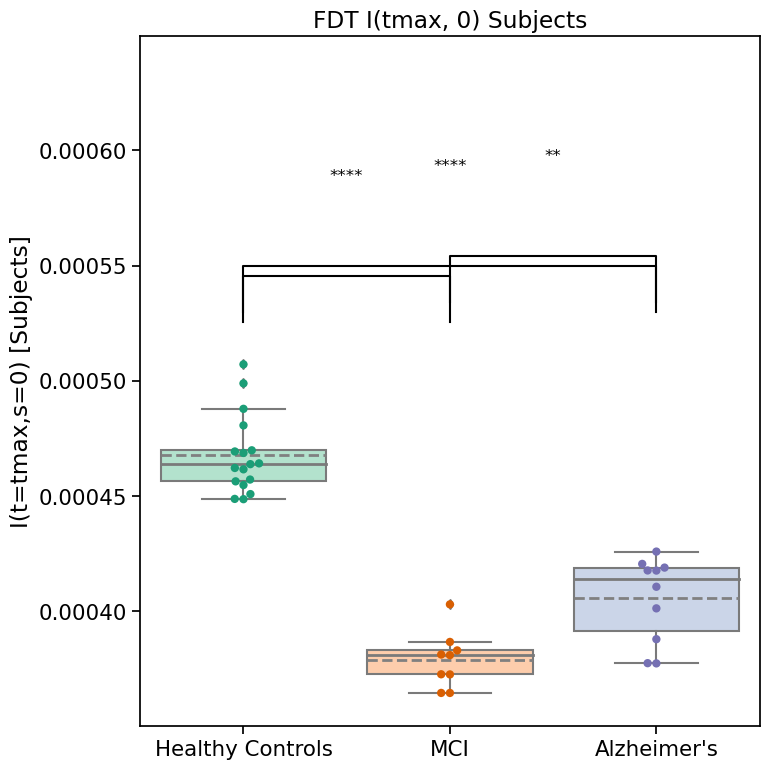

In [ ]:
### Box-plots for subjects (mean over parcells)
# I_HC = I_FDT_sub[0,:]
# I_MCI = I_FDT_sub[1,:]
# I_AD = I_FDT_sub[2,:]
I_HC = I_FDT_sub[cond_index_map['HC'], :group_sizes['HC']]
I_MCI = I_FDT_sub[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD = I_FDT_sub[cond_index_map['AD'], :group_sizes['AD']]
data = pd.DataFrame({
    "value": np.concatenate([I_HC, I_MCI, I_AD]),
    "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD)
})

filename = f"FDT_I_Boxplot_sub_COND_{COND}"
import inspect
#print(inspect.getsource(plot_boxes_HC_MCI_AD))

fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Subjects]',
            point_size = 6,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Subjects',
            saveplot = 1,
            filename=filename,
            dpi=300)

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_violinplots_WN3_v0.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.0)  # increase padding


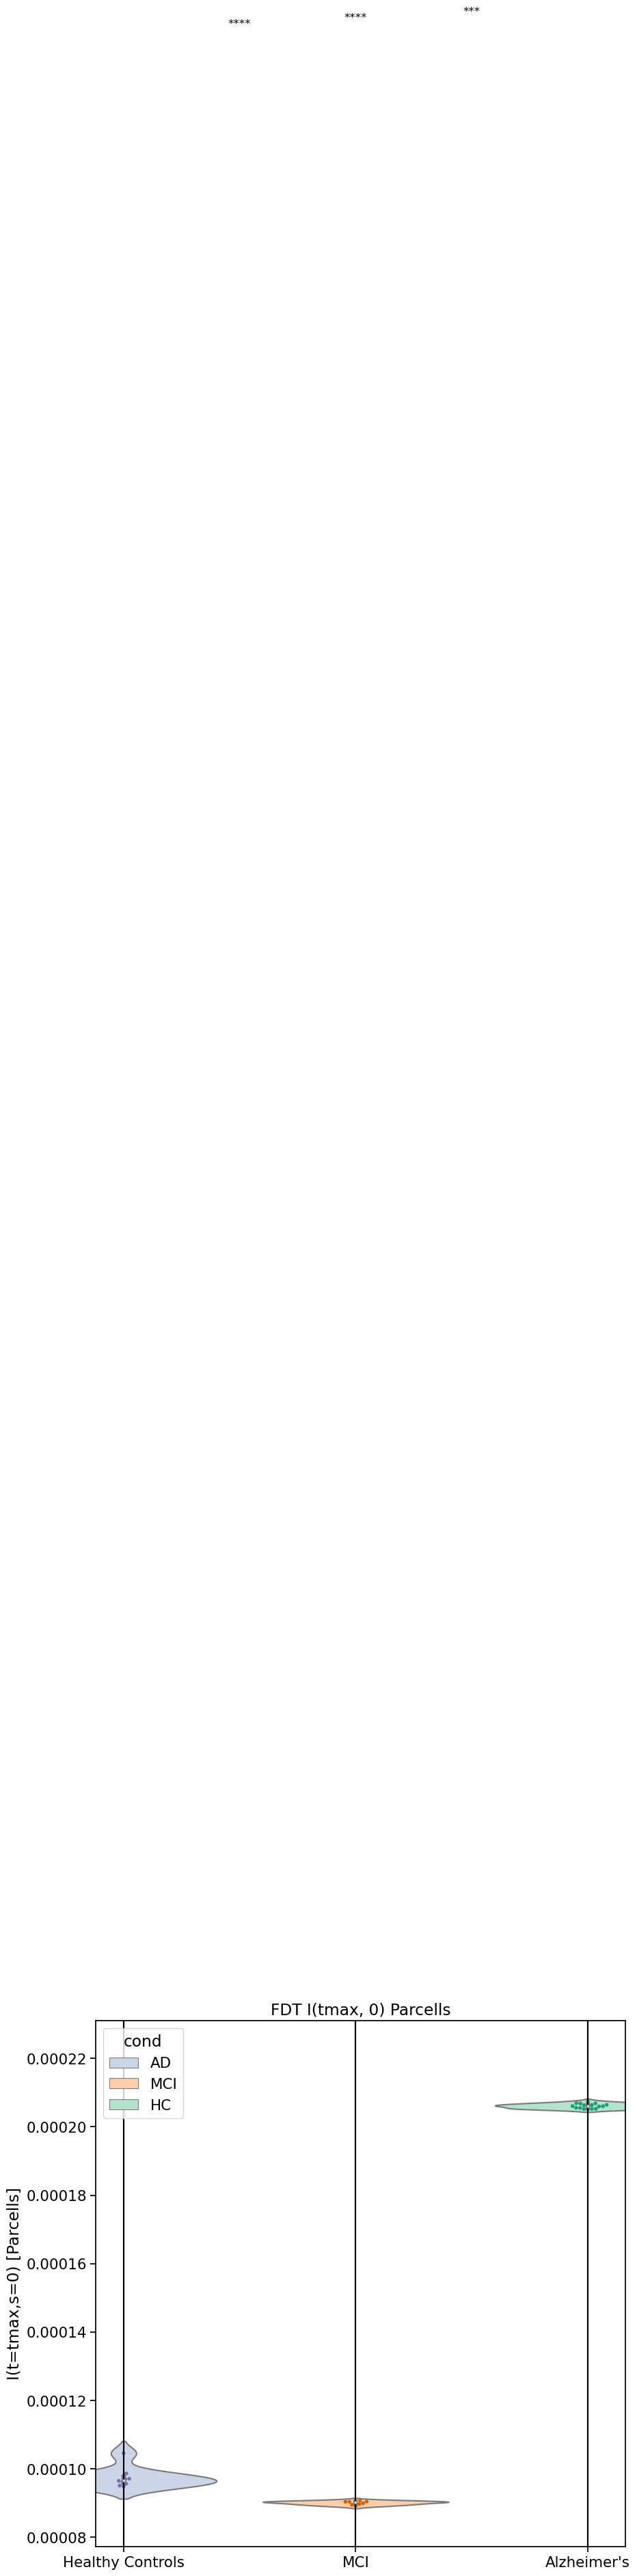

In [ ]:
### Violin-plots for parcells (mean over subjects)
I_HCpar = I_FDT_par[cond_index_map['HC'], :group_sizes['HC']]
I_MCIpar = I_FDT_par[cond_index_map['MCI'], :group_sizes['MCI']]
I_ADpar = I_FDT_par[cond_index_map['AD'], :group_sizes['AD']]
data = pd.DataFrame({
    "value": np.concatenate([I_ADpar, I_MCIpar, I_HCpar]),
    "cond": ["AD"] * len(I_ADpar) + ["MCI"] * len(I_MCIpar) + ["HC"] * len(I_HCpar)
})

filename = f"FDT_I_Violinplot_par_COND_{COND}"

fig, ax = plt.subplots(figsize=(10, 10))
plot_violins_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4,
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)

---

# TO DO:
- save FDT plots with coresponding filenames